#define model

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend
from data_mgmt import DAO
import matplotlib.pyplot as plt

In [6]:
def model_define(features, drop_rate):

    tf.summary.image("laser_inst", features)

    model = models.Sequential()

    model.add(layers.Conv2D(
        32, (11,1), padding="same", input_shape=(720,2,1),
        name="conv_1" ))
    model.add(layers.Conv2D(
        64, kernel_size=(5,1), padding="same",
        name="conv_2" ))
    model.add(layers.MaxPooling2D(
        (2,1), strides=2, padding="same",
        name="pool_1" ))
    model.add(layers.Conv2D(
        256, kernel_size=(5,1), padding="same",
        name="conv_3" ))
    model.add(layers.MaxPooling2D(
        (2,1), strides=4, padding="same",
        name="pool_2" ))

    model.add(layers.Flatten())

    model.add(layers.Dropout(drop_rate))
    model.add(layers.Dense(1024, activation="relu", name="dense_1"))

    model.add(layers.Dropout(drop_rate))
    model.add(layers.Dense(128, activation="relu", name="dense_2"))

    model.add(layers.Dense(3, name="dense_3"))

    return model

def pos_loss(y_actual, y_pred):
    loss_value = backend.sqrt(backend.pow((y_actual[:,0]-y_pred[:,0]),2)+backend.pow((y_actual[:,1]-y_pred[:,1]),2))+(0.3*backend.sqrt(backend.pow((y_actual[:,2]-y_pred[:,2]),2)))
    return loss_value

In [2]:
filename="laser_log/laser_log2303.csv"

data = DAO(filename)

data.read()
data.divide_data(0.25)

In [7]:
model_cnn = model_define(data.features, 0.2)

In [8]:
model_cnn.compile(optimizer = "adam",
    loss=pos_loss,
    metrics=['mean_absolute_error'])

In [ ]:
model_cnn.summary()

In [4]:
data.TR_features=tf.reshape(data.TR_features,[-1,720,2,1])
data.TS_features=tf.reshape(data.TS_features,[-1,720,2,1])
data.TR_targets=tf.reshape(data.TR_targets,[-1,3])
data.TS_targets=tf.reshape(data.TS_targets,[-1,3])

2022-03-30 09:45:30.796833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 09:45:30.802884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 09:45:30.803125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 09:45:30.804741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 09:45:30.804974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [5]:
data.TR_features

<tf.Tensor: shape=(950, 720, 2, 1), dtype=float64, numpy=
array([[[[11.7465 ],
         [-3.14159]],

        [[11.7625 ],
         [-3.13285]],

        [[11.7814 ],
         [-3.12411]],

        ...,

        [[11.9162 ],
         [ 3.12411]],

        [[11.742  ],
         [ 3.13285]],

        [[11.7391 ],
         [ 3.14159]]],


       [[[20.     ],
         [-3.14159]],

        [[20.     ],
         [-3.13285]],

        [[20.     ],
         [-3.12411]],

        ...,

        [[20.     ],
         [ 3.12411]],

        [[20.     ],
         [ 3.13285]],

        [[20.     ],
         [ 3.14159]]],


       [[[ 6.6188 ],
         [-3.14159]],

        [[ 6.60463],
         [-3.13285]],

        [[ 6.62915],
         [-3.12411]],

        ...,

        [[ 6.58683],
         [ 3.12411]],

        [[ 6.60129],
         [ 3.13285]],

        [[ 6.60718],
         [ 3.14159]]],


       ...,


       [[[20.     ],
         [-3.14159]],

        [[20.     ],
         [-3.13285]],



In [9]:
history = model_cnn.fit(data.TR_features, 
    data.TR_targets, 
    epochs=5, 
    validation_data=(data.TS_features, data.TS_targets)
    )


Epoch 1/5


2022-03-30 09:46:20.226687: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


30/30 [==============================] - 9s 48ms/step - loss: 20.4511 - mean_absolute_error: 9.7073 - val_loss: 2.8668 - val_mean_absolute_error: 1.4593
Epoch 2/5
30/30 [==============================] - 1s 34ms/step - loss: 2.7536 - mean_absolute_error: 1.4457 - val_loss: 1.6776 - val_mean_absolute_error: 0.8350
Epoch 3/5
30/30 [==============================] - 1s 36ms/step - loss: 2.3533 - mean_absolute_error: 1.2203 - val_loss: 1.7086 - val_mean_absolute_error: 0.8308
Epoch 4/5
30/30 [==============================] - 1s 35ms/step - loss: 1.9099 - mean_absolute_error: 0.9636 - val_loss: 2.0802 - val_mean_absolute_error: 0.9516
Epoch 5/5
30/30 [==============================] - 1s 34ms/step - loss: 1.8250 - mean_absolute_error: 0.9166 - val_loss: 1.7534 - val_mean_absolute_error: 0.8270


10/10 - 0s - loss: 1.7534 - mean_absolute_error: 0.8270 - 110ms/epoch - 11ms/step


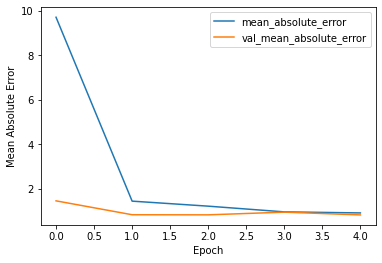

In [10]:
plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'], label = 'val_mean_absolute_error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')

test_loss, test_acc = model_cnn.evaluate(data.TS_features,  data.TS_targets, verbose=2)


8/8 - 1s - loss: 0.9760 - mean_absolute_error: 0.4660 - 857ms/epoch - 107ms/step


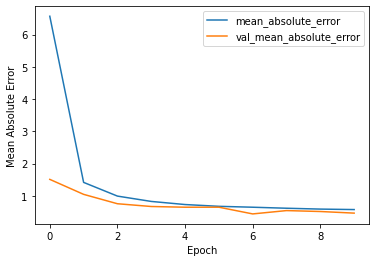

In [21]:
plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'], label = 'val_mean_absolute_error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')

test_loss, test_acc = model_cnn.evaluate(data.TS_features,  data.TS_targets, verbose=2)


#test data

In [1]:
import pandas as pd
import numpy as np

In [2]:
with open("data/laser_log/laser_log2203wmodify.csv", "r") as data:
    laser_db = pd.read_csv(data, delimiter=";").copy()

In [4]:
fill_value = 20

laser_list= pd.DataFrame()
target_list= pd.DataFrame()
inst = 1 #il counter delle istanze inizia da 1
laser_id = 0
new = True
#laser_angle=[]
#laser_range=[]
laser_inst=pd.Series(dtype="float32")
target_inst=pd.Series(dtype="float32")

for i in laser_db.values:
    if not new:
        if i[0] == inst:
            if i[3] == np.inf:
                laser_inst["range{}".format(laser_id)]=fill_value
                laser_inst["angle{}".format(laser_id)]=i[2]
            else:
                laser_inst["range{}".format(laser_id)]=i[3]
                laser_inst["angle{}".format(laser_id)]=i[2]                
            #laser_angle.append(i[2])
            #laser_range.append(i[3])
        else:
            if True:
                laser_inst["time"] = i[1]
            
            #laser_pd_series= pd.Series([laser_angle,laser_range], name=inst)
            #laser_list= pd.concat([laser_list,laser_pd_series], axis=1) 

            laser_inst.name=inst

            laser_list=pd.concat([laser_list, laser_inst.copy()],axis=1) 

            inst+=1

            new = True
            
    if new:
        target_inst["pos_x"] = i[4]
        target_inst["pos_y"] = i[5]
        target_inst["pos_yaw"] = i[6]
        target_inst.name= inst
        target_list=pd.concat([target_list,target_inst],axis=1)

        #laser_angle=[]
        #laser_range=[]

        #laser_angle.append(i[2])
        #laser_range.append(i[3]) 

        laser_id = 0

        if i[3] == np.inf:
            laser_inst["range{}".format(laser_id)]=fill_value
            laser_inst["angle{}".format(laser_id)]=i[2]
        else:
            laser_inst["range{}".format(laser_id)]=i[3]
            laser_inst["angle{}".format(laser_id)]=i[2]  
    
        new = False
        
    laser_id+=1

if True:
    laser_inst["time"] = i[1]

#laser_pd_series= pd.Series([laser_angle,laser_range], name=inst)
#laser_list= pd.concat([laser_list,laser_pd_series], axis=1) 

laser_inst.name=inst

laser_list=pd.concat([laser_list, laser_inst.copy()],axis=1) 